In [1]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_dir = '/content/drive/MyDrive/데이콘/데이콘 항공편 지연/데이콘_항공편_지연'

In [4]:
import numpy as np
import random
import os
import gc

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [6]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [7]:
csv_to_parquet(file_dir + '/train.csv', 'train')
csv_to_parquet(file_dir + '/test.csv', 'test')

train Done.
test Done.


In [8]:
train = pd.read_parquet('/content/train.parquet')
test = pd.read_parquet('/content/test.parquet')
sample_submission = pd.read_csv(file_dir+'/sample_submission.csv', index_col = 0)

                          결손값 개수  결손값_ratio
Delay                     744999   0.744999
Destination_State         109079   0.109079
Estimated_Arrival_Time    109040   0.109040
Estimated_Departure_Time  109019   0.109019
Origin_State              109015   0.109015
Carrier_ID(DOT)           108997   0.108997
Carrier_Code(IATA)        108990   0.108990
Airline                   108920   0.108920
Cancelled                      0   0.000000
Diverted                       0   0.000000
Origin_Airport                 0   0.000000
Origin_Airport_ID              0   0.000000
Month                          0   0.000000
Destination_Airport            0   0.000000
Destination_Airport_ID         0   0.000000
Day_of_Month                   0   0.000000
Distance                       0   0.000000
Tail_Number                    0   0.000000
ID                             0   0.000000
                          결손값 개수  결손값_ratio
Estimated_Arrival_Time    109048   0.109048
Carrier_ID(DOT)           109006

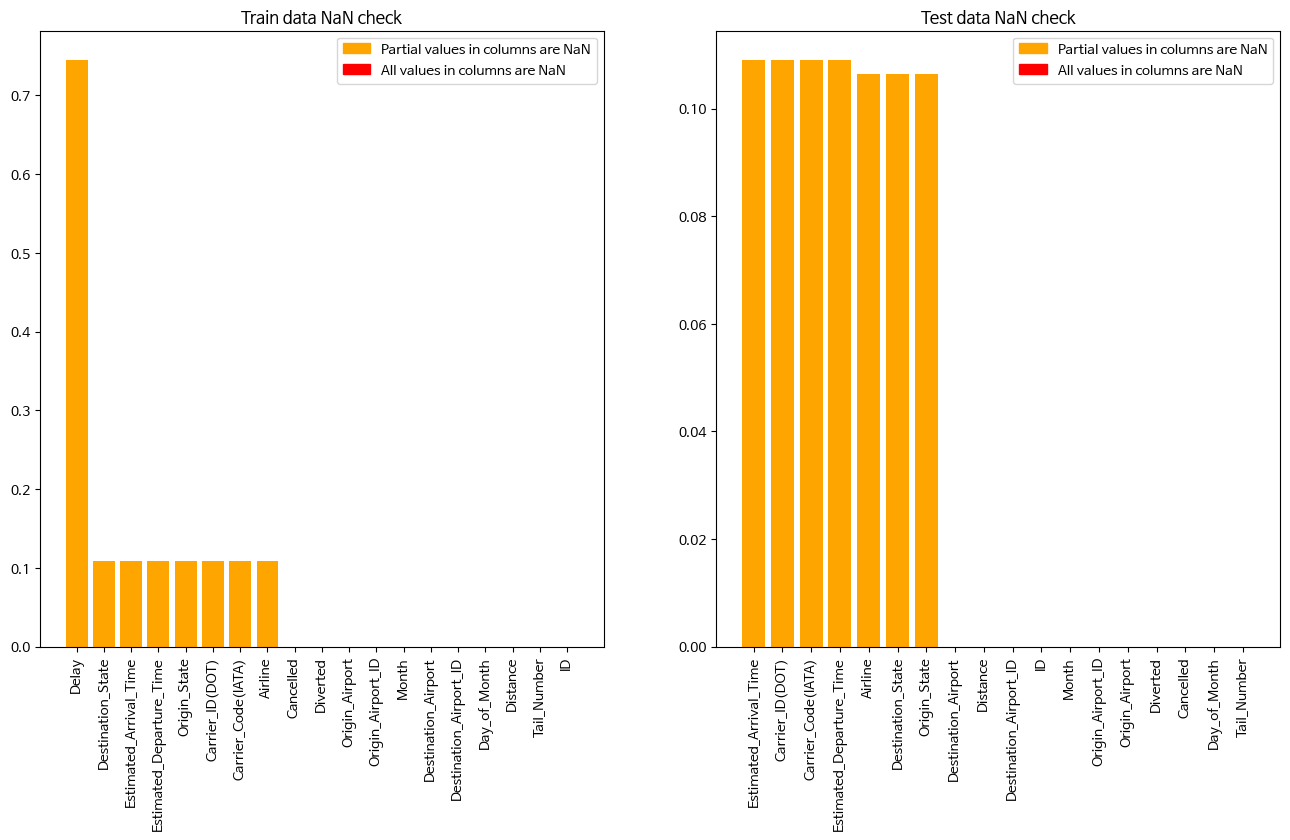

In [14]:
import matplotlib

matplotlib.rcParams['font.family'] = 'NanumBarunGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

column = ['결손값 개수']
axis_1 = pd.DataFrame(data = train.isnull().sum(axis=1), columns = column)
axis_1 = axis_1.sort_values(by = '결손값 개수', ascending = False)

train.isnull().sum(axis=0)
train_row_NaN = pd.DataFrame(train.isnull().sum(axis=0), columns = column)
train_row_NaN = train_row_NaN.sort_values(by = '결손값 개수', ascending = False)
train_row_su = train.shape[0]
train_row_NaN['결손값_ratio'] = train_row_NaN['결손값 개수']/train_row_su

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize = (16,8))
x = np.arange(len(train_row_NaN.index))
plt.subplot(1, 2, 1)
plt.xticks(x, train_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])

def color(data):
    if data == 1:
        return 'red'
    else:
        return 'orange'
plt.bar(x, train_row_NaN['결손값_ratio'], color = [color(i) for i in train_row_NaN['결손값_ratio']])
plt.title('Train data NaN check')

test.isnull().sum(axis=0)
test_row_NaN = pd.DataFrame(test.isnull().sum(axis=0), columns = column)
test_row_NaN = test_row_NaN.sort_values(by = '결손값 개수', ascending = False)
test_row_su = test.shape[0]
test_row_NaN['결손값_ratio'] = test_row_NaN['결손값 개수']/test_row_su

plt.subplot(1, 2, 2)
x2 = np.arange(len(test_row_NaN.index))
plt.xticks(x2, test_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])
plt.bar(x2, test_row_NaN['결손값_ratio'], color = [color(i) for i in test_row_NaN['결손값_ratio']])
plt.title('Test data NaN check')

print(train_row_NaN)
print(test_row_NaN)
plt.show()

기존 train 데이터로 self training을 진행하여 null이 있는 열을 학습시켜야함.
순서는 null이 적은 값부터 많은 순서대로 학습 <br>
Airline > Carrier_ID(DOT) > Carrier_Code(IATA) > Estimated_Departure_Time > Estimated_Arrival_Time > delay <br>  

예시로 Airline을 채우는 self_training에 대한 코드 

In [18]:
# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
 
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

label_st = train_lb.drop(columns = ['Airline'])
train_st = train_lb[(train_lb['Airline'].astype(str) != 'None')].drop(columns = ['Airline'])
X_nan = train_lb[(train_lb['Airline'].astype(str) == 'None')].drop(columns = ['Airline'])

# NULL이 없으면서 라벨링이 필요한 열들 정리
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(label_st[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])


사이킷런의 SelfTrainingClassifier을 사용하여 준지도학습

https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.SelfTrainingClassifier.html

다른 self_train으로는 

PyCaret: create_model() 함수에서 method 매개변수에 SelfTraining을 지정

Scikit-multilearn: Scikit-multilearn의 MLkNN 분류기

ModAL: ModAL은 SelfLearner 클래스

가 있다고 합니다. (by Chat_gpt)

In [11]:
# Airline self_training
original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

X = train_st[original_col]
y = train_lb[(train_lb['Airline'].astype(str) != 'None')][original_col + ['Airline']]['Airline']

stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    verbose = True)

stclf.fit(X, y)    

/usr/local/lib/python3.9/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


SelfTrainingClassifier(base_estimator=RandomForestClassifier(), verbose=True)

In [19]:
# 결과값 삽입

X_nan['Airline_pred'] = stclf.predict(X_nan[original_col])
train_lb.loc[train_lb['Airline'].astype(str) == 'None', 'Airline'] = X_nan['Airline_pred']

In [20]:
train_lb[train_lb['Airline'].isna()]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay


In [21]:
train_lb['Airline'].unique()

array(['Southwest Airlines Co.', 'SkyWest Airlines Inc.',
       'American Airlines Inc.', 'United Air Lines Inc.',
       'Republic Airlines', 'ExpressJet Airlines Inc.',
       'Delta Air Lines Inc.', 'Air Wisconsin Airlines Corp',
       'Horizon Air', 'JetBlue Airways', 'Spirit Air Lines',
       'Alaska Airlines Inc.', 'Mesa Airlines Inc.',
       'Frontier Airlines Inc.', 'Trans States Airlines',
       'Endeavor Air Inc.', 'Comair Inc.', 'Capital Cargo International',
       'Envoy Air', 'Hawaiian Airlines Inc.', 'Allegiant Air',
       'Virgin America', 'Peninsula Airways Inc.', 'Compass Airlines',
       'GoJet Airlines, LLC d/b/a United Express',
       'Commutair Aka Champlain Enterprises, Inc.',
       'Empire Airlines Inc.', 'Cape Air'], dtype=object)